In [66]:
import math
import os
import torch
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings
import torch
import numpy as np
import random
from torch.optim              import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers             import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from tsfm_public              import TimeSeriesForecastingPipeline 
from tsfm_public              import TimeSeriesPreprocessor
from tsfm_public              import TinyTimeMixerForPrediction
from tsfm_public              import TrackingCallback
from tsfm_public              import count_parameters
from tsfm_public              import get_datasets


from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from sklearn.metrics import precision_score, recall_score, f1_score
import ast
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
device             = "cuda" if torch.cuda.is_available() else "cpu"
load_path          =  "ibm-granite/granite-timeseries-ttm-r2"
os.makedirs('baseline_results', exist_ok=True)


tickers = ["AAPL",
           "TSLA",
           "XOM",
           "SPY",
           "JNJ",
           "AMD",
           "PG"
          ]

event_titles = ["AAPL – Crash & Rebound (2020-03-10)",
                "TSLA – High-Beta Cooling (2021-01-15)",
                "XOM – Oil Cycle Peak (2022-06-01)",
                "SPY – Drawdown Chop (2022-09-15)",
                "JNJ – Low-Volatility Stretch (2019-08-01)",
                "AMD – Tech Selloff (2018-10-10)",
                "PG – Macro-Irrelevant Calm (2015-06-15)"
                ]

starts = ["2019-09-02",
          "2020-07-01",
          "2021-10-01",
          "2022-01-03",
          "2018-11-01",
          "2018-04-02",
          "2014-12-01"
         ]

ends   = ["2020-06-01",
          "2021-06-30",
          "2022-09-30",
          "2022-12-30",
          "2020-01-01",
          "2019-03-29",
          "2016-01-01"
         ]

column_specifiers = {
        "timestamp_column": "date",
        "id_columns": [],
        "target_columns": ["close"],
        "control_columns": ["open","high","low"] 
        }



###  Μοντελοποίηση Πρόβλεψης με TinyTimeMixer

####  Προεπεξεργασία:
- Χρησιμοποιείται ο `TimeSeriesPreprocessor` για μετατροπή των δεδομένων σε κατάλληλη μορφή εισόδου για το μοντέλο.
- Ορίζονται βασικές παράμετροι:
  - `context_length = 512`
  - `prediction_length = 96`
  - `scaling = True`
  - `scaler_type = "standard"`
- O preprocessor εκπαιδεύεται στο dataset

####  Φόρτωση μοντέλου TinyTimeMixer:
- Το μοντέλο φορτώνεται με την συνάρτηση `from_pretrained()` .

####  Δημιουργία splits και pipeline:
- Το dataset χωρίζεται σε train/test με 40% για testing.
- Ορίζεται pipeline `TimeSeriesForecastingPipeline`:

- Γίνονται προβλέψεις στο test set και στο window.

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

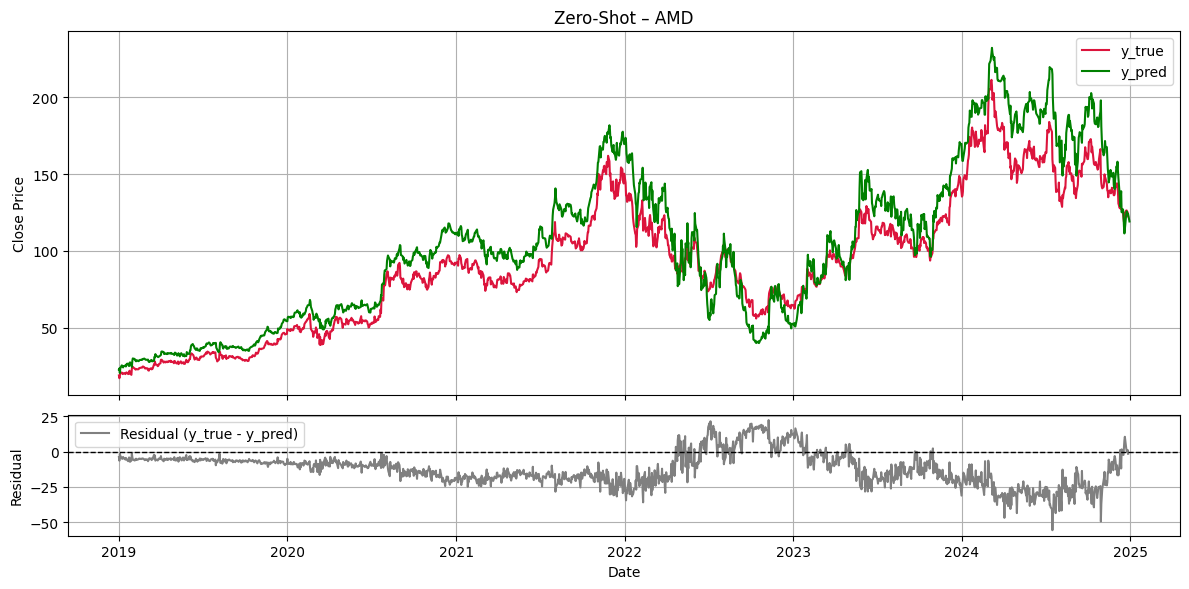

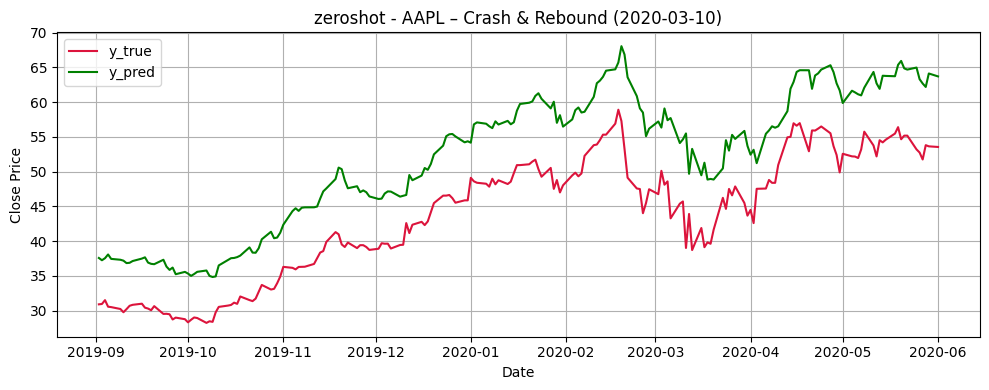

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

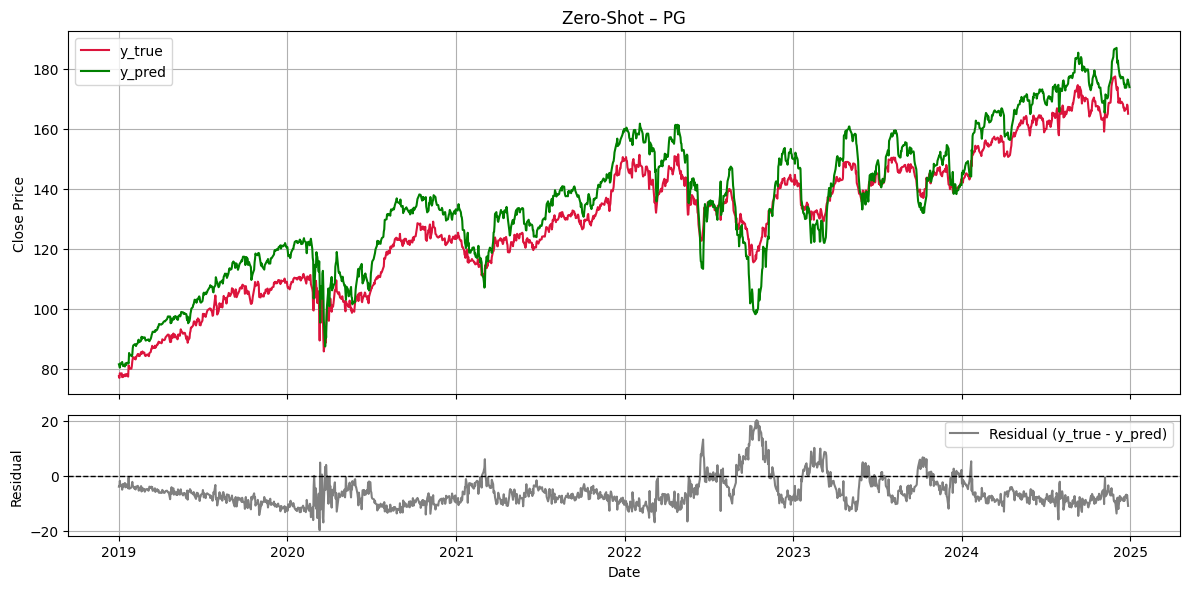

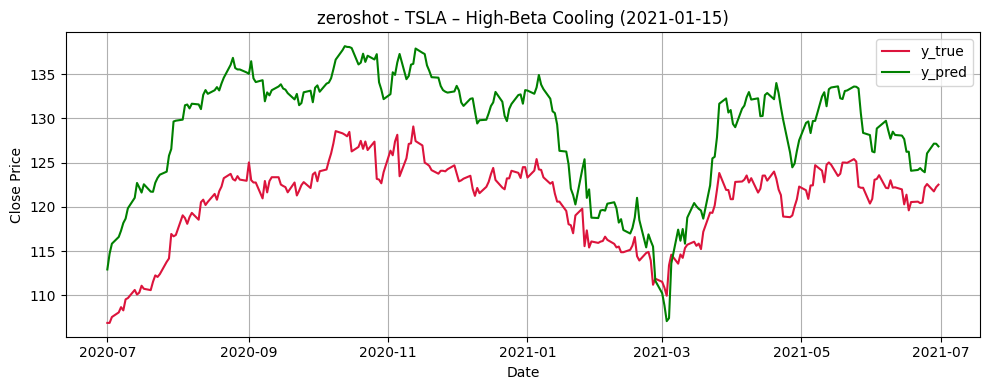

0


In [68]:
total_evaluation_time = 0

for ticker,start,end,event_title in zip(tickers,starts,ends,event_titles):
    df = pd.read_csv(f"./processed_data/{ticker}.csv", parse_dates=["date"])

    
    preprocessor = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length     = 512,
        prediction_length  = 96,
        scaling            = True,
        encode_categorical = False,
        scaler_type        = "standard",
    )
    
    preprocessor.train(df)

    pmodel = TinyTimeMixerForPrediction.from_pretrained(
        load_path , 
        num_input_channels             = preprocessor.num_input_channels,
        prediction_channel_indices     = preprocessor.prediction_channel_indices,
        exogenous_channel_indices      = preprocessor.exogenous_channel_indices,
        fcm_use_mixer                  = False,
        #fcm_context_length            = 10,
        enable_forecast_channel_mixing = False,
        decoder_mode                   = "mix_channel",
    )

    
    _, _, test_df = prepare_data_splits(
        df,
        context_length=512,
        split_config={"train": 0.0, "test": 0.4}
    )
    
    pipeline = TimeSeriesForecastingPipeline(
        pmodel,
        device            = device,
        feature_extractor = preprocessor,
        batch_size        = 64,
    )


    forecast = pipeline(test_df)
    
    forecast["date"]     = pd.to_datetime(forecast["date"])
    forecast["y_true"]   = forecast["close"].str[0]
    forecast["y_pred"]   = forecast["close_prediction"].str[0]
    forecast["residual"] = forecast["y_true"] - forecast["y_pred"]
    output_path          = os.path.join('baseline_results', f'{ticker}_results.csv')
    forecast.to_csv(output_path, index=False)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(forecast["date"], forecast["y_true"], label="y_true", color='crimson')
    ax1.plot(forecast["date"], forecast["y_pred"], label="y_pred", color='green')
    ax1.set_title(f"Zero-Shot – {ticker}")
    ax1.set_ylabel("Close Price")
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(forecast["date"], forecast["residual"], label="Residual (y_true - y_pred)", color='gray')
    ax2.axhline(0, linestyle='--', color='black', linewidth=1)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Residual")
    ax2.grid(True)
    ax2.legend()
    plt.savefig(f'./baseline_results/{ticker}.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    forecast         = pipeline(df)
    mask             = (forecast["date"] >= start) & (forecast["date"] <= end)
    event            = forecast.loc[mask]
    event["y_true"]  = event["close"].str[0]
    event["y_pred"]  = event["close_prediction"].str[0]
    output_path      = os.path.join('baseline_results', f'{ticker}_event_results.csv')
    event.to_csv(output_path, index=False)
    
    
    
    plt.figure(figsize=(10, 4))
    plt.plot(event["date"], event["y_true"], label="y_true", color='crimson')
    plt.plot(event["date"], event["y_pred"], label="y_pred", color='green')
    plt.title(f"zeroshot - {event_title}")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./baseline_results/{ticker}_event.png', dpi=300, bbox_inches='tight')
    plt.show()
print(total_evaluation_time)

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

def metrics(actual, prediction):
    a = np.stack(actual).flatten()
    p = np.stack(prediction).flatten()
    mask = ~np.isnan(a) & ~np.isnan(p)
    a, p = a[mask], p[mask]

    # errors
    mae  = np.mean(np.abs(a - p))
    rmse = np.sqrt(np.mean((a - p)**2))
    mape = np.mean(np.abs((a - p) / (a + 1e-8))) * 100

    # direction
    actual_diff = np.sign(np.diff(a))
    pred_diff   = np.sign(np.diff(p))
    hit_rate = np.mean(actual_diff == pred_diff)

    actual_up = actual_diff > 0
    pred_up   = pred_diff   > 0
    precision = precision_score(actual_up, pred_up, zero_division=0)
    recall    = recall_score(actual_up, pred_up, zero_division=0)
    f1        = f1_score(actual_up, pred_up, zero_division=0)

    return dict(mae=mae, rmse=rmse, mape=mape,
                hit_rate=hit_rate,
                precision=precision, recall=recall, f1=f1)


## Table 1

In [70]:
results = []
tickers = ["AAPL",
           "TSLA",
           "XOM",
           "SPY",
           "JNJ",
           "AMD",
           "PG"
          ]
for ticker in tickers:
    df = pd.read_csv(f'baseline_results/{ticker}_results.csv')
    df = df.dropna(subset=["y_true", "y_pred"])
    m = metrics(df["y_true"].values, df["y_pred"].values)
    m["ticker"] = ticker
    results.append(m)


baseline_df = pd.DataFrame(results).set_index("ticker")
print(baseline_df)
output_path = os.path.join("baseline_results", "baseline_output.csv")
baseline_df.to_csv(output_path)


               mae        rmse       mape  hit_rate  precision    recall  \
ticker                                                                     
AAPL     19.337226   21.230296  14.685712  0.466411   0.504525  0.545900   
TSLA    119.909735  139.263337  60.996074  0.485129   0.510968  0.511628   
XOM       6.962484    7.805010  10.864140  0.483045   0.489873  0.505222   
SPY      34.581392   39.031402   8.610831  0.484325   0.527809  0.554893   
JNJ       4.418395    4.902356   3.101978  0.500960   0.518135  0.516796   
AMD      14.300802   16.736906  16.417075  0.479207   0.477778  0.511229   
PG        7.239170    8.005718   5.766632  0.472809   0.508235  0.527473   

              f1  
ticker            
AAPL    0.524397  
TSLA    0.511298  
XOM     0.497429  
SPY     0.541012  
JNJ     0.517464  
AMD     0.493937  
PG      0.517675  


## Table 2

In [71]:
results = []

for ticker in tickers:
    df = pd.read_csv(f'baseline_results/{ticker}_event_results.csv')
    df = df.dropna(subset=["y_true", "y_pred"])
    m = metrics(df["y_true"].values, df["y_pred"].values)
    m["ticker"] = ticker
    results.append(m)

events_df = pd.DataFrame(results).set_index("ticker")
print(events_df)
output_path = os.path.join("baseline_results", "events_output.csv")
events_df.to_csv(output_path)

               mae        rmse       mape  hit_rate  precision    recall  \
ticker                                                                     
AAPL      8.447937    9.077641  12.728268  0.435897   0.487603  0.556604   
TSLA    137.127439  148.662611  70.228404  0.430769   0.460938  0.437037   
XOM       7.831465    8.247491  10.760892  0.496154   0.543624  0.570423   
SPY      36.714256   41.467493   9.116192  0.478764   0.406780  0.444444   
JNJ       3.420191    3.663680   2.951857  0.457237   0.518750  0.509202   
AMD       8.257578    8.501257  19.387907  0.487179   0.535088  0.575472   
PG        8.090977    8.672878   6.683149  0.492308   0.529412  0.537313   

              f1  
ticker            
AAPL    0.519824  
TSLA    0.448669  
XOM     0.556701  
SPY     0.424779  
JNJ     0.513932  
AMD     0.554545  
PG      0.533333  


## Table 3

In [72]:
regime_map = {
    "TSLA": "High-Volatility",
    "AMD": "High-Volatility",
    "SPY": "Sideways/Chop",
    "PG": "Low-Volatility",
    "JNJ": "Low-Volatility",
    "AAPL": "Post-Trend Reversal",
    "XOM": "Post-Trend Reversal"
}

baseline_df['regime_type'] = baseline_df.index.map(regime_map)
grouped_df = baseline_df.groupby('regime_type').mean(numeric_only=True)
output_path = 'baseline_results/regime_output.csv'
grouped_df.to_csv(output_path)
print(grouped_df)

                           mae       rmse       mape  hit_rate  precision  \
regime_type                                                                 
High-Volatility      67.105269  78.000122  38.706575  0.482168   0.494373   
Low-Volatility        5.828783   6.454037   4.434305  0.486884   0.513185   
Post-Trend Reversal  13.149855  14.517653  12.774926  0.474728   0.497199   
Sideways/Chop        34.581392  39.031402   8.610831  0.484325   0.527809   

                       recall        f1  
regime_type                              
High-Volatility      0.511428  0.502618  
Low-Volatility       0.522134  0.517570  
Post-Trend Reversal  0.525561  0.510913  
Sideways/Chop        0.554893  0.541012  


## Directional Accuracy

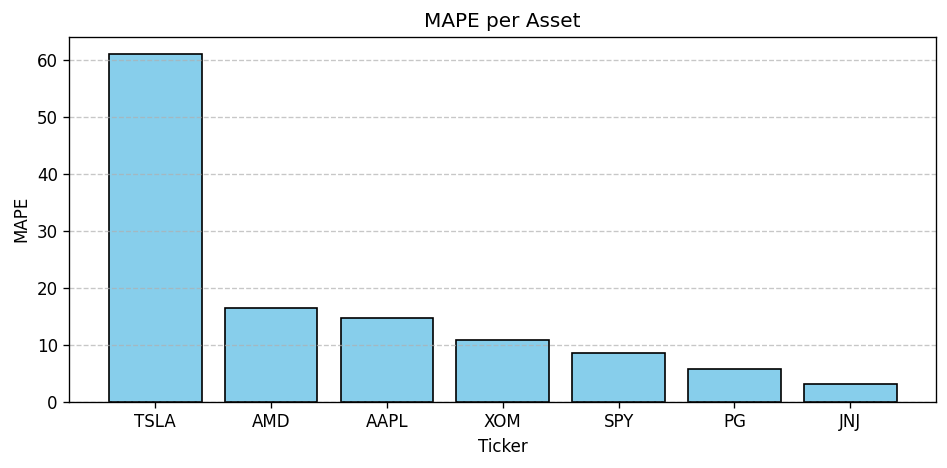

In [77]:
baseline_df_sorted = baseline_df.sort_values("mape", ascending=False)


plt.figure(figsize=(8, 4), dpi=120)
plt.bar(baseline_df_sorted.index, baseline_df_sorted["mape"], color="skyblue", edgecolor="black")
plt.title("MAPE per Asset")
plt.xlabel("Ticker")
plt.ylabel("MAPE")
#plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Rankings

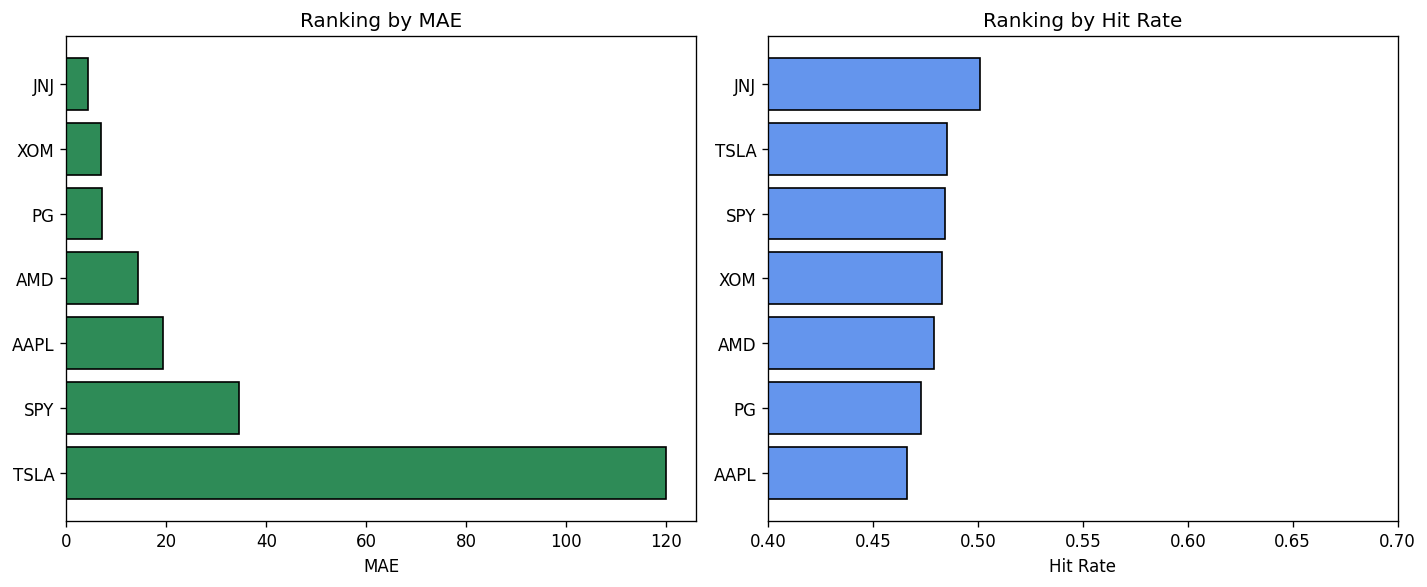

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

df_mae = baseline_df.sort_values("mae", ascending=True)
axes[0].barh(df_mae.index, df_mae["mae"], color="seagreen", edgecolor="black")
axes[0].set_title("Ranking by MAE")
axes[0].set_xlabel("MAE")
axes[0].invert_yaxis() 

df_hit = baseline_df.sort_values("hit_rate", ascending=False)
axes[1].barh(df_hit.index, df_hit["hit_rate"], color="cornflowerblue", edgecolor="black")
axes[1].set_title("Ranking by Hit Rate")
axes[1].set_xlabel("Hit Rate")
axes[1].set_xlim(0.4, 0.7)
axes[1].invert_yaxis()  
plt.tight_layout()
plt.show()

## Error distribution

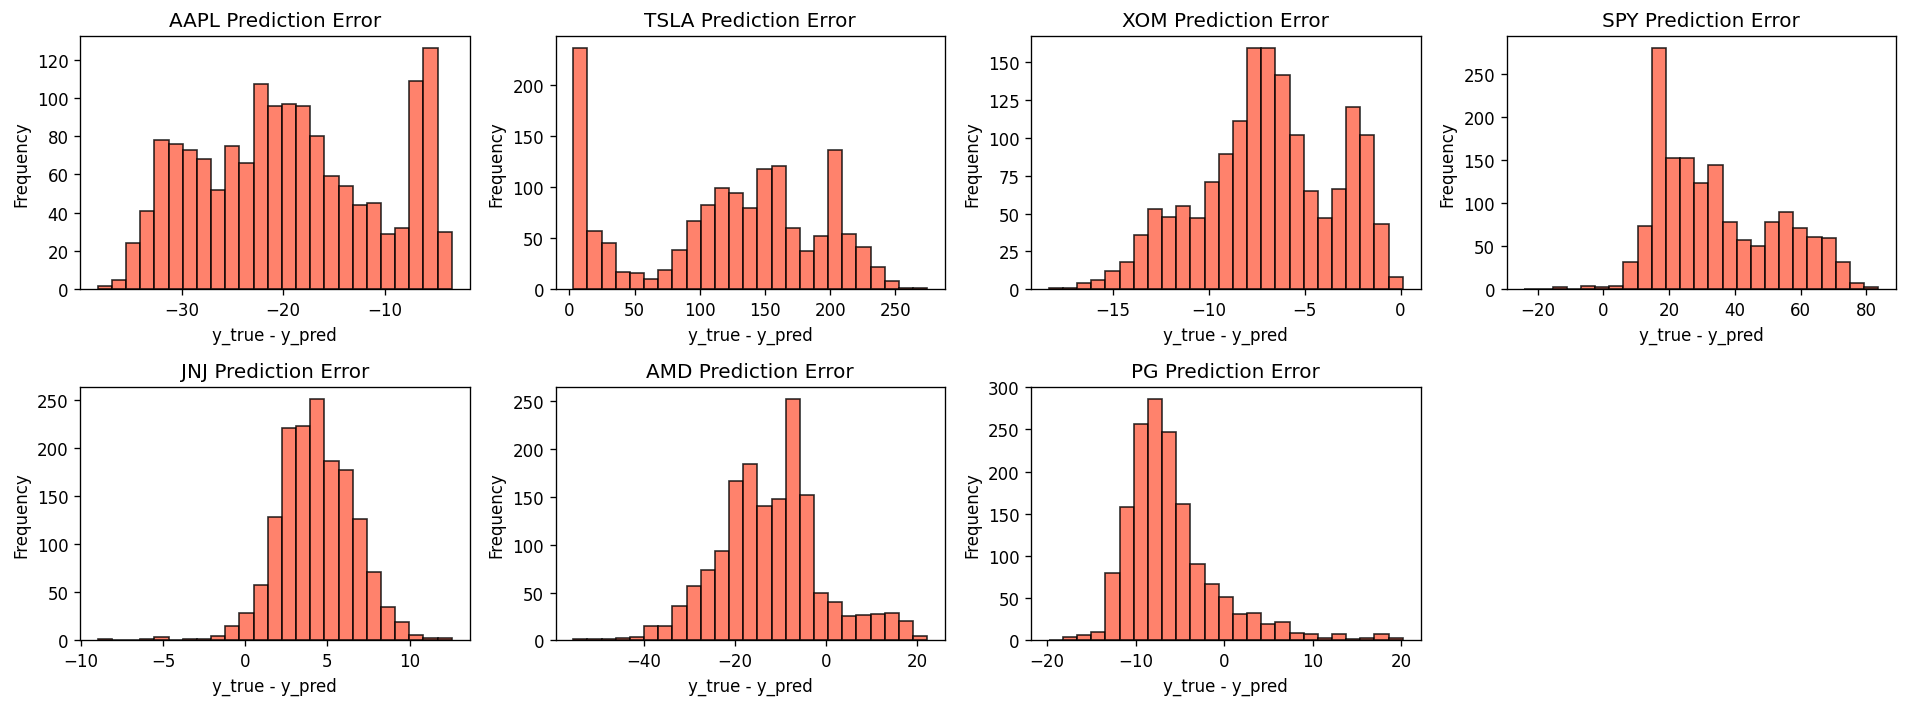

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), dpi=120)
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    path = f'baseline_results/{ticker}_results.csv'
    df = pd.read_csv(path)
    
    errors = df['y_true'] - df['y_pred']
    errors = errors.dropna()

    ax = axes[i]
    ax.hist(errors, bins=25, color='tomato', edgecolor='black', alpha=0.8)
    ax.set_title(f"{ticker} Prediction Error")
    ax.set_xlabel("y_true - y_pred")
    ax.set_ylabel("Frequency")


for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Metric to volatility correlation analysis

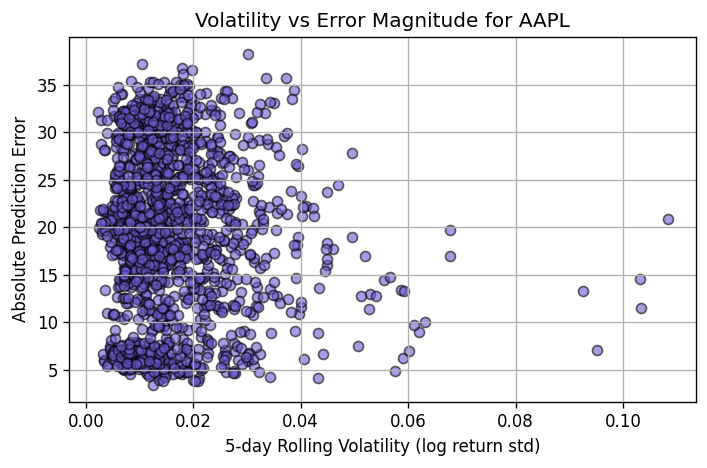

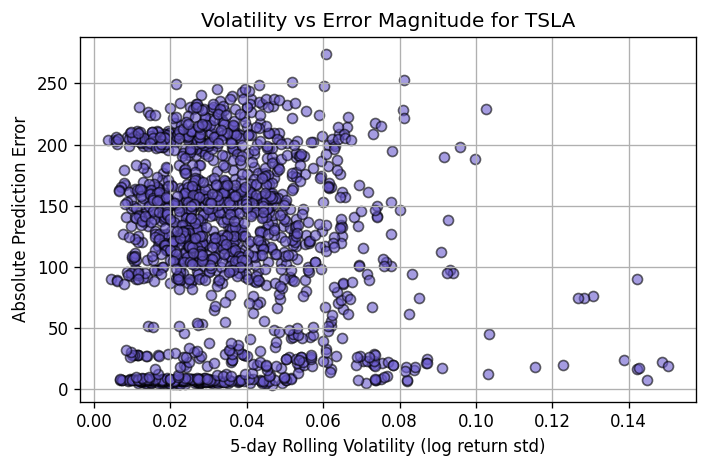

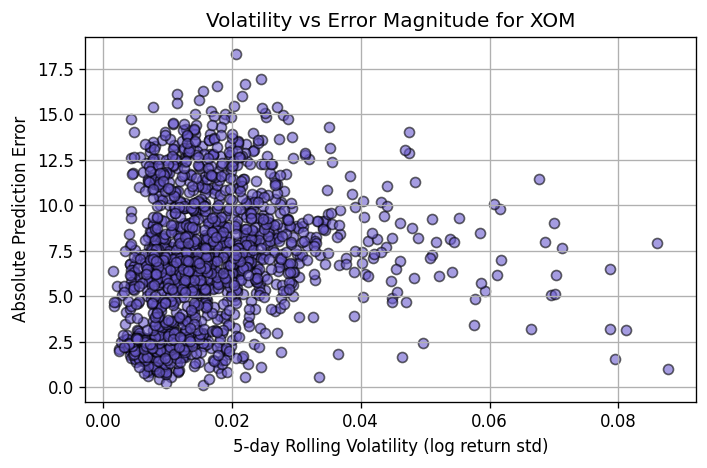

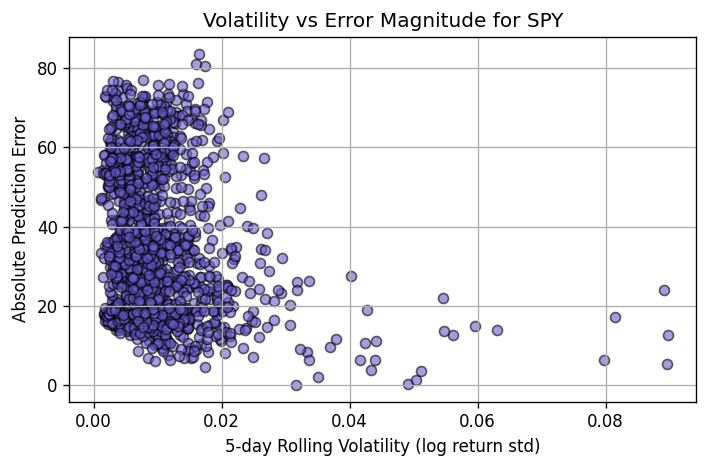

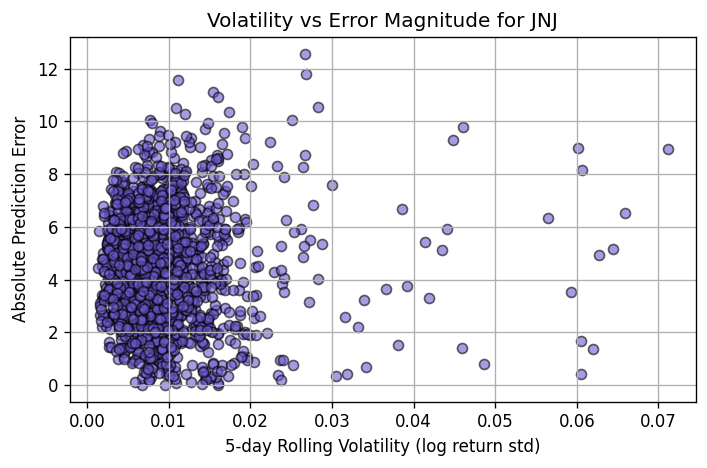

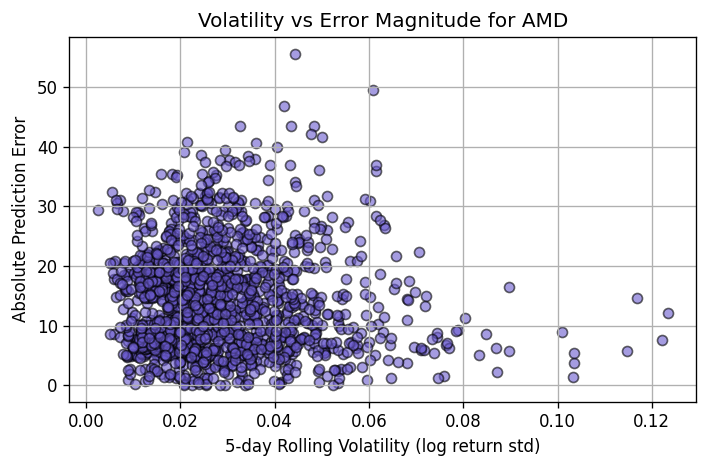

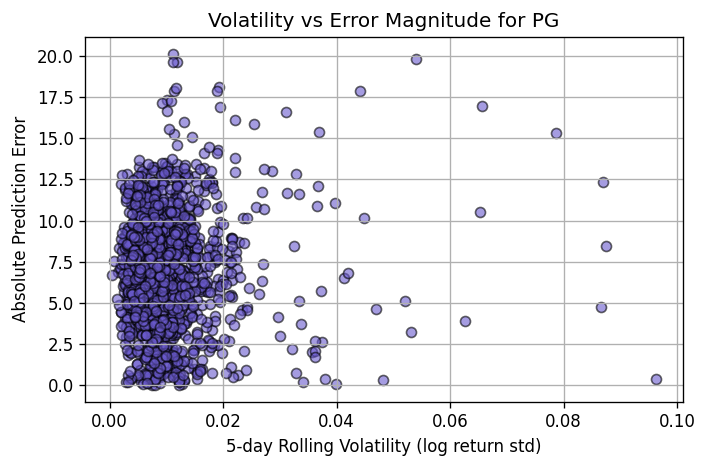

Pearson Correlation (Volatility vs Error) 
AAPL:  -0.04263453605650314
TSLA:  -0.0641219776212724
XOM:  0.18311988182100622
SPY:  -0.18168657157583273
JNJ:  0.042498447856690116
AMD:  -0.046251245600677185
PG:  0.016026025032126523


In [86]:
from scipy.stats import pearsonr
pear = []
for ticker in tickers:

    df = pd.read_csv(f"baseline_results/{ticker}_results.csv")
    df['log_return'] = np.log(df['y_true']).diff()
    df['rolling_volatility'] = df['log_return'].rolling(window=5).std()
    df['abs_error'] = np.abs(df['y_true'] - df['y_pred'])
    df_clean = df.dropna(subset=['rolling_volatility', 'abs_error'])
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    plt.scatter(df_clean['rolling_volatility'], df_clean['abs_error'], alpha=0.6, color='slateblue', edgecolor='black')
    plt.title(f"Volatility vs Error Magnitude for {ticker}")
    plt.xlabel("5-day Rolling Volatility (log return std)")
    plt.ylabel("Absolute Prediction Error")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./baseline_results/{ticker}_rolling_volatility.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    corr, pval = pearsonr(df_clean['rolling_volatility'], df_clean['abs_error'])
    pear.append(corr)

i = 0
print(f"Pearson Correlation (Volatility vs Error) ")
for ticker in tickers:
    
    print(f'{ticker}: ',pear[i])    
    i=i+1